In [1]:
import torch 
import numpy as np
import pandas as pd
from torch import nn
import torch.nn.functional as F
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from ray import tune
import ray
from ray import train, tune
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
import copy
import threading
from  sklearn.mixture import GaussianMixture as GMM
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super().__init__()
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers
        self.hidden_layers_encoder = []
        self.hidden_layers_decoder = []
        
        
 
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.bottleneck_layer = nn.Linear(bottleneck_size, bottleneck_size)
        
        self.hidden_layers_decoder.append(nn.Linear(bottleneck_size, hidden_size))
        
        for i in range(layers -1):
            self.hidden_layers_encoder.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers_encoder.append(nn.ReLU())
            self.hidden_layers_decoder.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers_decoder.append(nn.ReLU())
            
        self.hidden_layers_encoder.append(nn.Linear(hidden_size, bottleneck_size))
        
        self.encoder = nn.Sequential(self.input_layer,
                                   *self.hidden_layers_encoder,
                                   self.bottleneck_layer)
        
        self.decoder = nn.Sequential(*self.hidden_layers_decoder,
                                   self.output_layer)
        
        self.model = nn.Sequential(self.encoder, self.decoder)
        
    
        
    def encode(self, x):
        return self.encoder(x)
        
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))    
    
    def calculate_loss(self, X):
        error_type = nn.MSELoss()
        reconstructed = self.forward(X)
        loss = error_type(reconstructed, X)
        return loss
    
    def train_autoencoder(self, X_train, ts_size, epochs, lr=.01):
            indices = torch.randperm(len(X_train))[:ts_size]
            X_train = X_train[indices]
            error_type = nn.MSELoss()
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
            losses = []
            for epoch in range(epochs):
                loss = self.calculate_loss(X_train)
                losses.append(loss)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            
            return self, losses
                
    
    

In [3]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)        
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None
    
    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        noise =  np.random.normal(0, noise * data.max(), data.shape)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(Y_train), torch.FloatTensor(Y_test)

In [61]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.1, name="moons")

In [5]:
def autoencoder_as_function_of_hyperparameters(config):
    auto, _ = AutoEncoder(config["input_size"], config["bottleneck_size"], 
                    config["hidden_size"], config["layers"]).train_autoencoder(X_train, 
                           config["ts_size"], 
                           config["epochs"], 
                           config["lr"])
    loss_func = nn.MSELoss()
    loss = float(loss_func(auto.forward(X_test), X_test).detach().numpy())
    metric = {"loss": loss }
    ray.train.report(metric
       )

In [6]:
config={"input_size":  tune.choice([2]), "bottleneck_size":  tune.choice([1]),
        "hidden_size":  tune.choice([x for x in range(80, 200, 10)]), 
        "layers":  tune.choice([x for x in range(1, 10)]),
        "ts_size":  tune.choice([x for x in range(100, 2000, 100)]),
        "epochs":  tune.choice([x for x in range(10, 400, 50)]),
        "lr": tune.choice([0.01, 0.001])}

from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.ax import AxSearch
def opt(config):
    ax_search = AxSearch()
    algo = OptunaSearch()
    algo = ConcurrencyLimiter(algo, max_concurrent=4)

    tuner = tune.Tuner(
        autoencoder_as_function_of_hyperparameters,
        tune_config=tune.TuneConfig(
            scheduler=ASHAScheduler(),
            search_alg=algo,
            metric="loss",
            mode="min",
            num_samples=20,
        ),
        param_space=config,
    )

    result = tuner.fit()
    return result.get_best_result().config
good_config = opt(config)


2023-11-21 11:41:10,009	INFO tune.py:1045 -- Total run time: 60.36 seconds (60.32 seconds for the tuning loop).


In [60]:
good_config = {'input_size': 2,
 'bottleneck_size': 1,
 'hidden_size': 130,
 'layers': 3,
 'ts_size': 1000,
 'epochs': 310,
 'lr': 0.001}

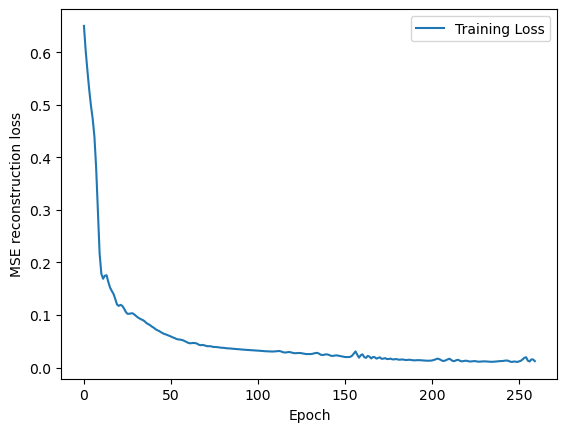

In [8]:
auto, loss_list = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           good_config["ts_size"], 
                           good_config["epochs"], 
                           good_config["lr"])
plt.plot(range(good_config["epochs"]), [l.detach().numpy() for l in loss_list], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('MSE reconstruction loss')
plt.legend()
plt.show()


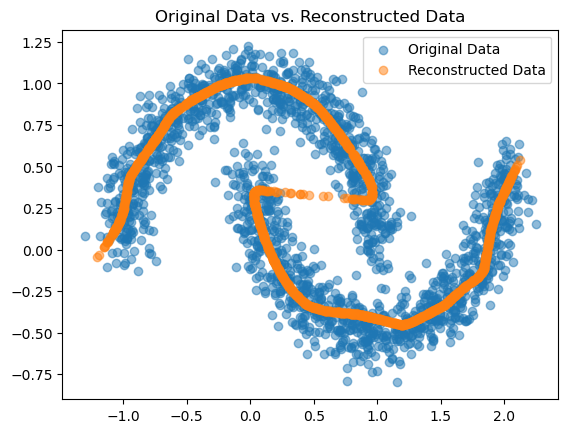

In [9]:
reconstructed_data = auto.forward(X_train).detach().numpy()
plt.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.5)
plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Original Data vs. Reconstructed Data')
plt.show()

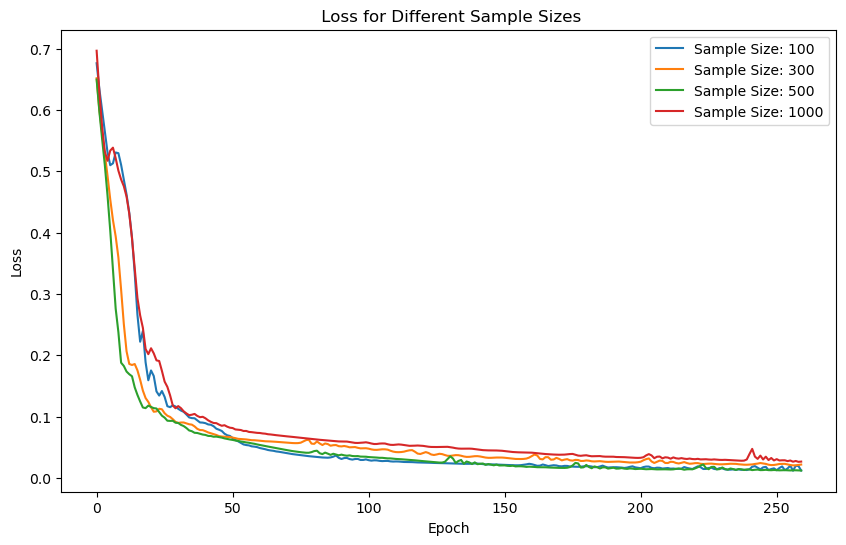

hidden_size: 100
layers: 5


In [10]:
#Train model with different data size
data_size = [100,300,500,1000]
num_epochs = 150

input_size=2
bottleneck_size=1
hidden_size=100
layers=5
Loss = []
for size in data_size:
    auto, loss_list  = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           size, 
                           good_config["epochs"], 
                           good_config["lr"])
    Loss.append([l.detach().numpy() for l in loss_list])


# Plot
plt.figure(figsize=(10, 6))
for i, size in enumerate(data_size):
    plt.plot(range(good_config["epochs"]), Loss[i], label=f"Sample Size: {size}")

plt.title(' Loss for Different Sample Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


print('hidden_size:', hidden_size)
print('layers:',layers)

In [62]:
def generate_plots():
    
    fig, axs = plt.subplots(2,3)
    fig.suptitle(f"Reconstruction error vs parameters")
    fig.text(0, 0.5, 'MSE Reconstruction', va='center', rotation='vertical')
    fig.tight_layout() 
    i = 0
    for param in good_config:
        loss = []
        if param == "input_size":
            continue
        x_axis = np.linspace(1, 2*good_config[param], 10, dtype=type(good_config[param]))
        gc = copy.deepcopy(good_config)
        for p in x_axis:
            gc[param] = p
            auto, _ =  AutoEncoder(gc["input_size"], gc["bottleneck_size"], 
                            gc["hidden_size"], gc["layers"]).train_autoencoder(X_train, 
                                   gc["ts_size"], 
                                   gc["epochs"], 
                                   gc["lr"])

            loss.append(float(auto.calculate_loss(X_test).detach().numpy()))

        axs[divmod(i, 3)].set_xlabel(f"{param}")
        axs[divmod(i, 3)].plot(x_axis, loss)
        axs[divmod(i, 3)].set_yscale('log')
        i += 1
    


    

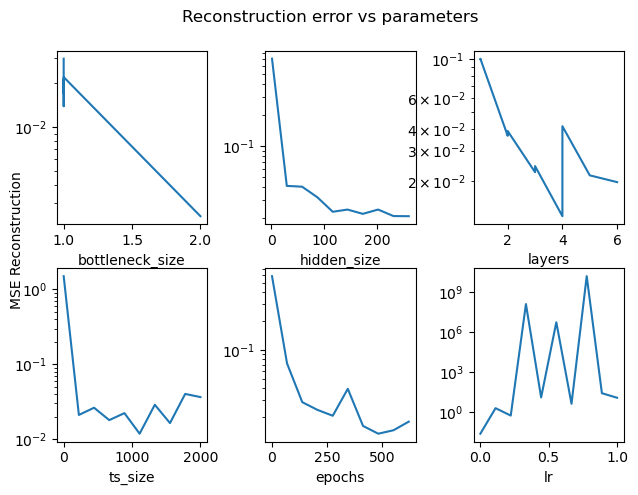

In [63]:
generate_plots()

In [13]:
#visualization

def visualization(epoch):
    data_size = [100,300,500,1000]
    loaded_epoch = epoch
    fig, axs = plt.subplots(2, 2,squeeze=False)
    for i, ax in enumerate(axs.flat):

        ax.scatter(X_train[0:data_size[i],0],X_train[0:data_size[i],1],label='Original Data', alpha=0.5)
        #Load parameters of autoencoder model
     
        auto, _ = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           data_size[i], 
                           loaded_epoch, 
                           good_config["lr"])
    
        reconstructed_data = auto.forward(X_train[0:data_size[i]])
        reconstructed_data = np.array([r.detach().numpy() for r in reconstructed_data])
        ax.scatter(reconstructed_data.T[0],reconstructed_data.T[1], label='Reconstructed Data', alpha=0.5)

        ax.legend()
        ax.set_title('Data Set Size='+str(data_size[i]))


    plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
    fig.suptitle('Epoch='+str(loaded_epoch), y=1.5,fontsize=30)

    plt.show()


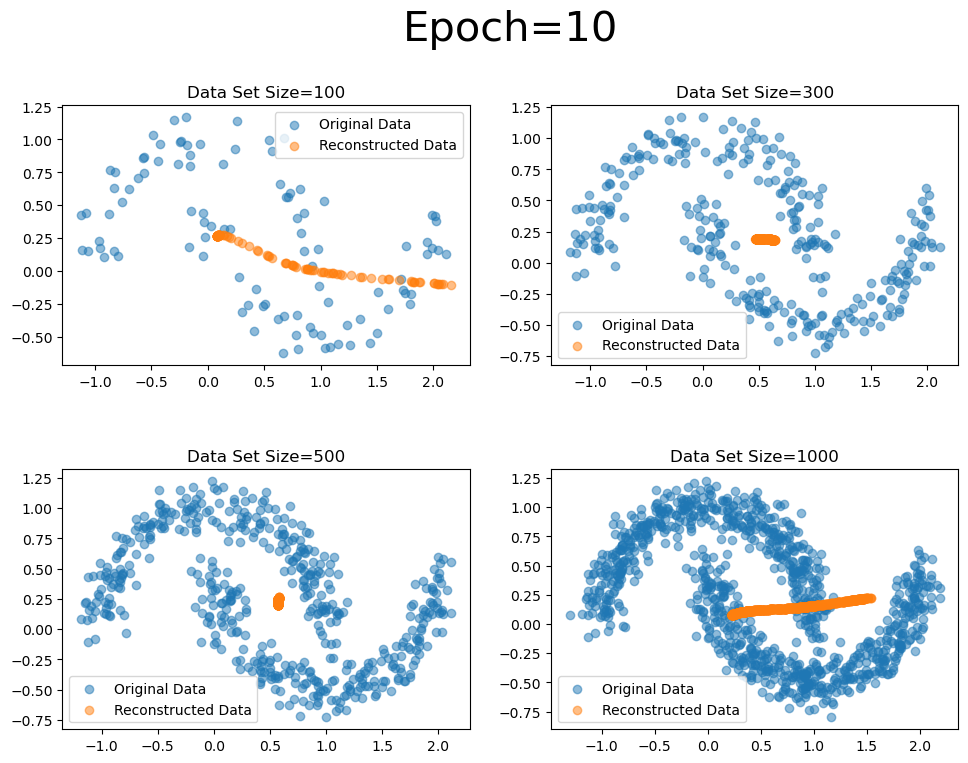

In [14]:
visualization(10)

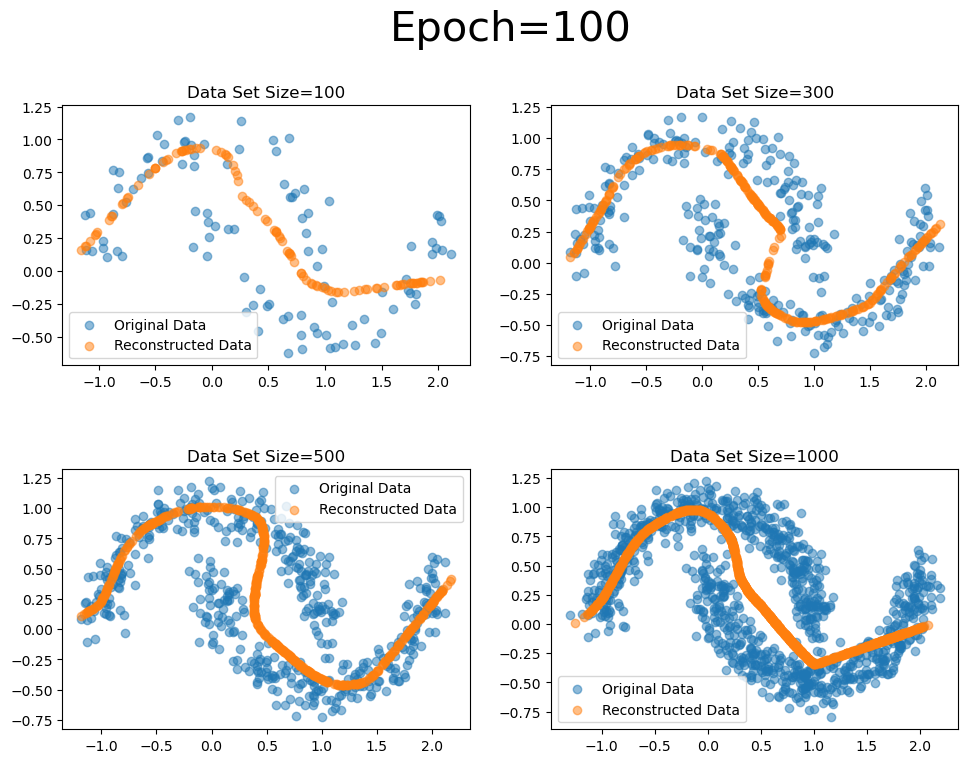

In [15]:
visualization(100)

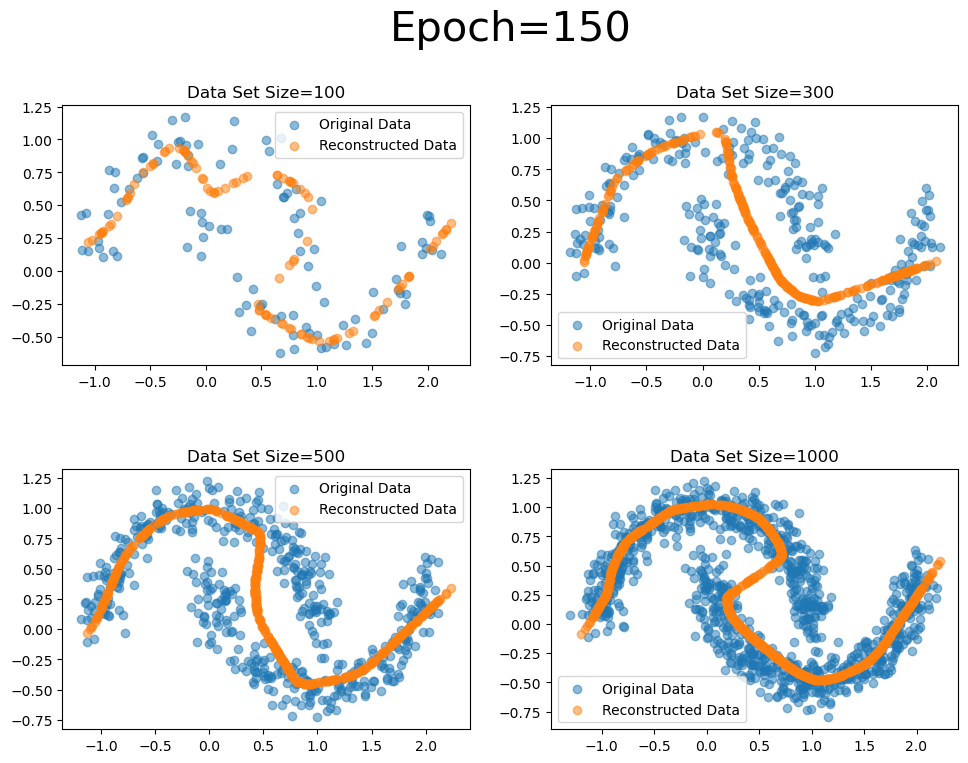

In [16]:
visualization(150)

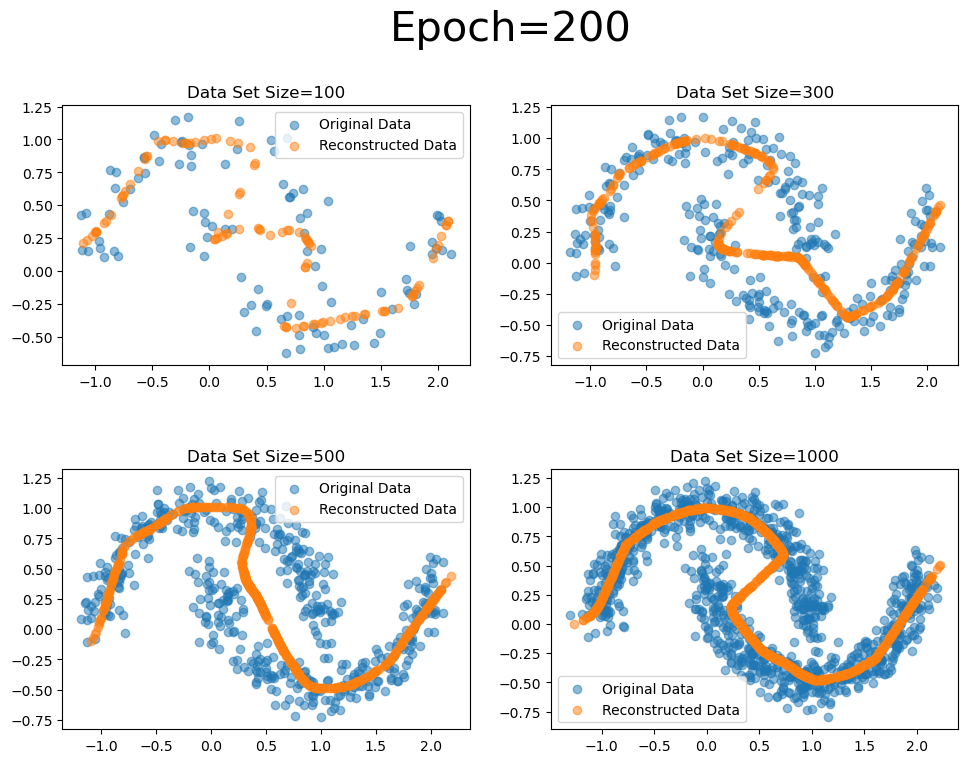

In [17]:
visualization(200)

#1.2 For the best hyperparameter settings you found, investigate how much the reconstruction varies when you repeat training with the same or diffeerent datasets. Comment on your observations.

#1.3 Create and visualize a histogram of the code distribution. Fit a Gaussian mixture model to the code distribution and use it to sample synthetic data. Comment on the quality of the generated data.

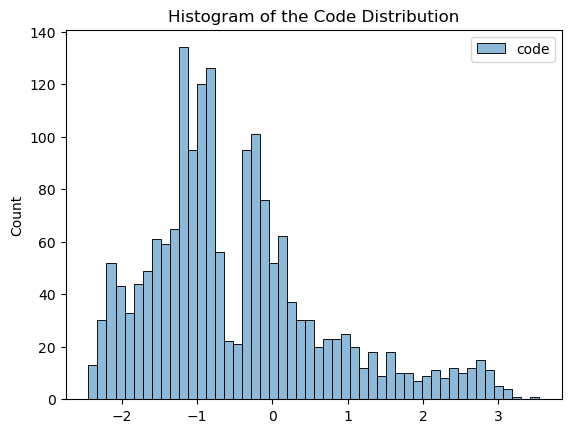

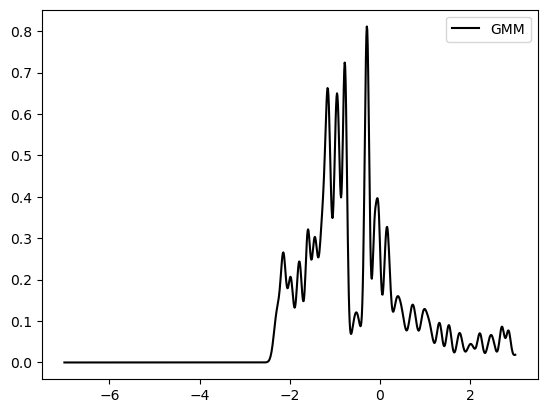

In [18]:
#1.3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import seaborn as sns

auto, _ = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           good_config["ts_size"], 
                           good_config["epochs"], 
                           good_config["lr"])
code = auto.encode(X_train)
reconstructed_data = auto.decode(code)
code = np.array([c.detach().numpy() for c in code])
reconstructed_data = np.array([r.detach().numpy() for r in reconstructed_data])
#Use GMM to fit code
n_components=30
gmm=GaussianMixture( n_components,random_state=42)
gmm.fit(code)


x = np.linspace(-7, 3, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


#Plot histogram
sns.histplot(code, bins=50, label='code')
plt.xlim=(-7,3)
plt.title('Histogram of the Code Distribution')
plt.legend()
plt.show()



plt.plot(x, pdf, '-k', label='GMM')
plt.xlim=(-7,3)
plt.legend()

plt.show()


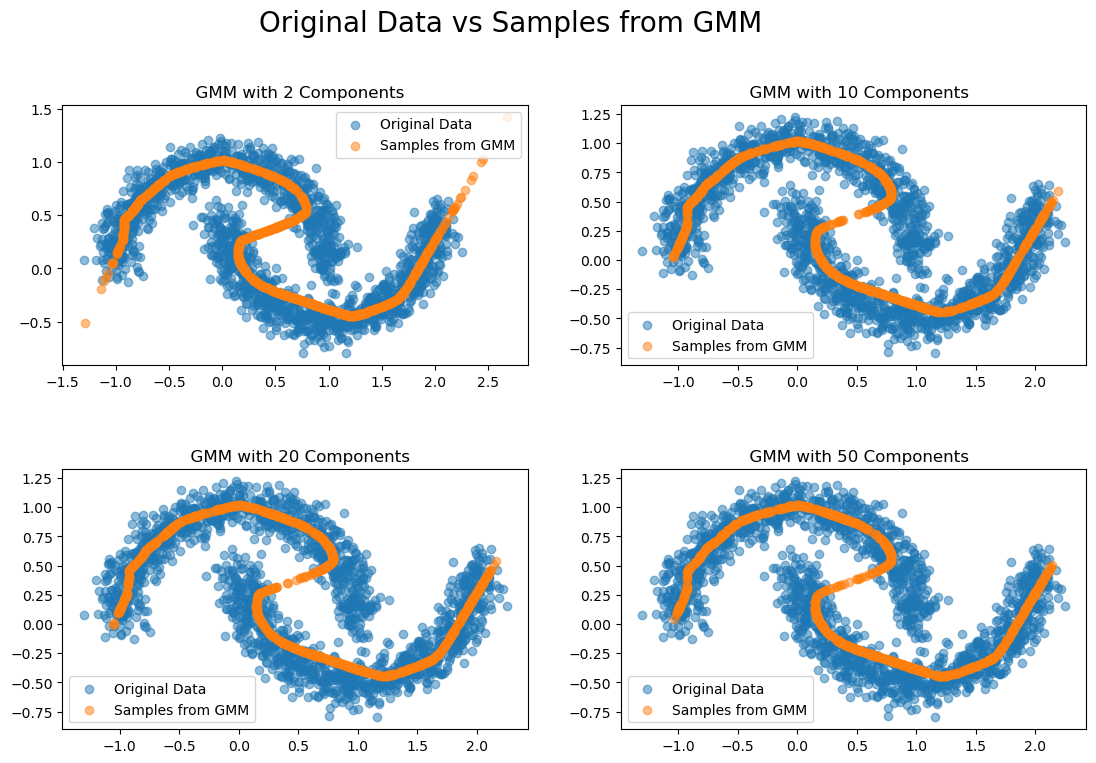

In [19]:
#Visualizing the generated samples from GMM with different components
components_list=[2,10,20,50]
fig, axs = plt.subplots(2, 2,squeeze=False)
for i,ax in enumerate(axs.flat):
    #fitting GMM
    gmm=GaussianMixture( components_list[i],random_state=42)
    gmm.fit(code)


    #Generating samples from GMM
    n_samples=1000
    GMM_samples, _ = gmm.sample(n_samples)
    GMM_samples = torch.FloatTensor(GMM_samples)

    reconstructed_data = auto.decode(GMM_samples)
    reconstructed_data = np.array([r.detach().numpy() for r in reconstructed_data])

    ax.scatter(X_train[:, 0], X_train[:, 1], label='Original Data', alpha=0.5)
    ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Samples from GMM', alpha=0.5)
    ax.legend()
    ax.set_title('  GMM with '+str(components_list[i])+' Components')

plt.subplots_adjust(left=-0.2, right=1.4, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Original Data vs Samples from GMM', y=1.5,fontsize=20)

plt.show()



#1.4 Check if the autoencoder still works (without retraining!) on a test set at noise level 0.2.

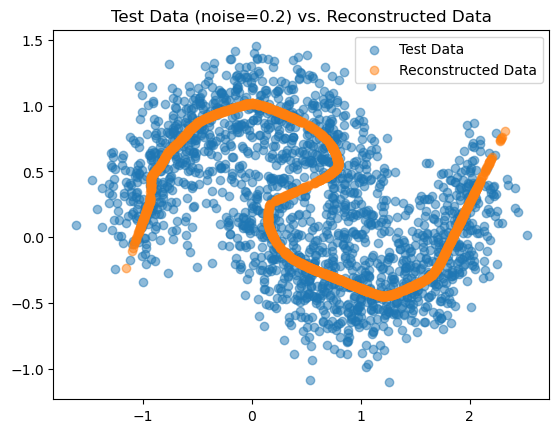

In [20]:
#1.4

X_train, X_test, Y_train, Y_test = import_data(noise=0.2, n_test=0.1, name="moons")
reconstructed_data = auto.forward(X_train)
reconstructed_data = np.array([r.detach().numpy() for r in reconstructed_data])


plt.scatter(X_train[:, 0], X_train[:, 1], label='Test Data', alpha=0.5)


plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Test Data (noise=0.2) vs. Reconstructed Data')
plt.show()


#1.5 Train an autoencoder with a training set at noise level 0.2 and comment on how the geometry of the reconstructed set changes.

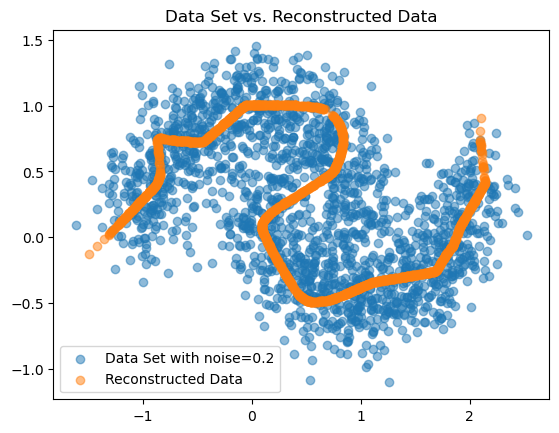

In [21]:
auto, _ = AutoEncoder(good_config["input_size"], good_config["bottleneck_size"], 
                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                           good_config["ts_size"], 
                           good_config["epochs"], 
                           good_config["lr"])
reconstructed_data = auto.forward(X_train)
reconstructed_data = np.array([r.detach().numpy() for r in reconstructed_data])

plt.scatter(X_train[:, 0], X_train[:, 1], label='Data Set with noise=0.2', alpha=0.5)
plt.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)
plt.legend()
plt.title('Data Set vs. Reconstructed Data')
plt.show()


#Task 2

In [22]:
#Redefine the MMD function we defined at last assignment with tensor form
def squared_distances(X, Y):
    """
    Compute the squared Euclidean distances between each pair of points in the two datasets X and Y.

    :param X: Array of shape (n_samples_X, n_features).
    :param Y: Array of shape (n_samples_Y, n_features).
    :return: Matrix of shape (n_samples_X, n_samples_Y) where each element represents the squared distance.
    """
    # Expand the squares of X and Y
    X_square = torch.sum(X**2, dim=1, keepdim=True)
    Y_square = torch.sum(Y**2, dim=1, keepdim=True)

    # Compute the squared distances
    squared_dist = X_square  -2 * torch.matmul(X, Y.t()) + Y_square.t()
    return squared_dist

def se_kernel_custom(X, Y, gamma=None):
    """
    Compute the Radial Basis Function (RBF) kernel (squared exponential) between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the RBF kernel. If None, it's set to 1/n_features.
    :return: RBF kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return torch.exp(-gamma * sq_dists)

def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = torch.mean(kernel_XX) + torch.mean(kernel_YY) - 2 * torch.mean(kernel_XY)
    return torch.sqrt(mmd_square)  # Return the square root to get MMD

In [23]:
#Autoencoder model with different weights
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
import numpy as np



n_samples = 1000

X, _ = make_moons(n_samples, noise=0.1, random_state=42)
X = torch.FloatTensor(X)

#Samples from a 2-dimensional standard normal
mean=[0,0]
covariance=[[1,0],[0,1]]
samples = np.random.multivariate_normal(mean, covariance, n_samples)
samples = torch.FloatTensor(samples)


dataset = TensorDataset(X, X)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 150
input_size=2
bottleneck_size=2
hidden_size=100
layers=5
Loss = []
code_list=[]
reconstructed_list=[]

#hyperparameter: bandwidth
gamma=5.5
#weight of Loss_mse
weight_list=[0.2, 0.4, 0.6, 0.8]
for weight in weight_list:
    model = AutoEncoder(input_size,bottleneck_size,hidden_size,layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    Loss_epoch = []
    for epoch in range(num_epochs):
        for data in data_loader:
            inputs, _ = data

            #Forward
            code = model.encode(inputs)
            outputs = model.decode(code)


            #Loss_mse
            loss_mse = criterion(outputs, inputs)
            #Loss_MMD
            kernel_XX_se = se_kernel_custom(code, code,gamma=gamma)
            kernel_YY_se = se_kernel_custom(samples, samples,gamma=gamma)
            kernel_XY_se = se_kernel_custom(code, samples,gamma=gamma)
            loss_MMD=compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se)

            #Loss_total
            loss=weight*loss_mse+(1-weight)*loss_MMD

            #Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Loss_epoch.append(loss.item())
    code = model.encode(X)
    outputs = model.decode(code)
    code_list.append(code)
    reconstructed_list.append(outputs)
    torch.save(model.state_dict(),'model'+str(weight) +'.pth')

    Loss.append(Loss_epoch)


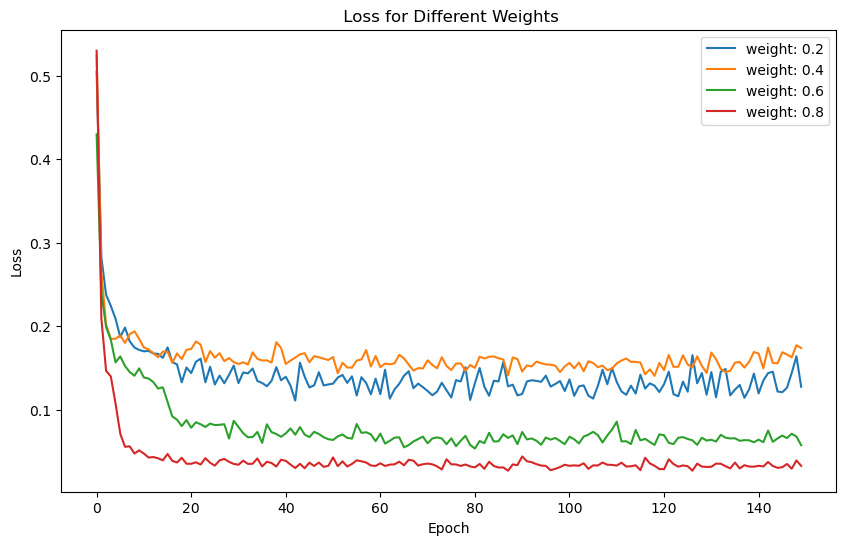

torch.Size([1000, 2])


In [24]:
plt.figure(figsize=(10, 6))
for i, weight in enumerate(weight_list):
    plt.plot(range(num_epochs), Loss[i], label=f"weight: {weight}")

plt.title(' Loss for Different Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(reconstructed_list[1].shape)

#Visualize the reconstructed vs. original data, and the code distribution. Check that the reconstruction error is much less than what you got with a bottleneck of size 1. Generate synthetic data by passing standard normal samples through the decoder and visualize their quality. Comment on your findings.

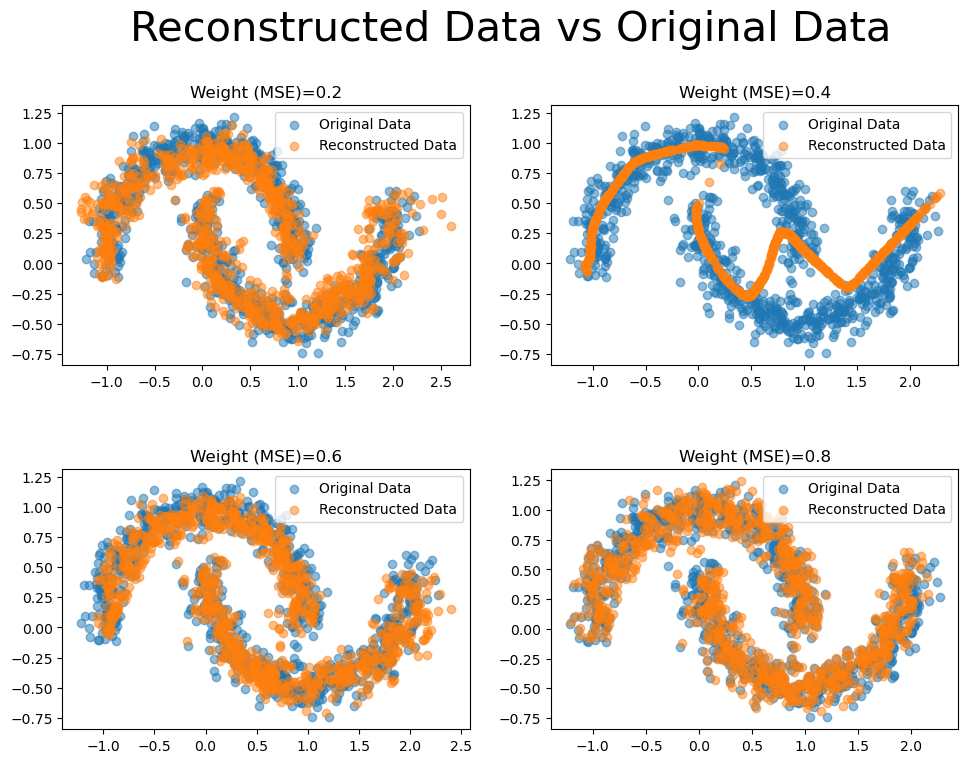

In [25]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):
    ax.scatter(X[:,0],X[:,1],label='Original Data', alpha=0.5)

    reconstructed_data=reconstructed_list[i].detach().numpy()

    ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)

    ax.legend()
    ax.set_title('Weight (MSE)='+str(weight_list[i]))


plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Reconstructed Data vs Original Data', y=1.5,fontsize=30)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


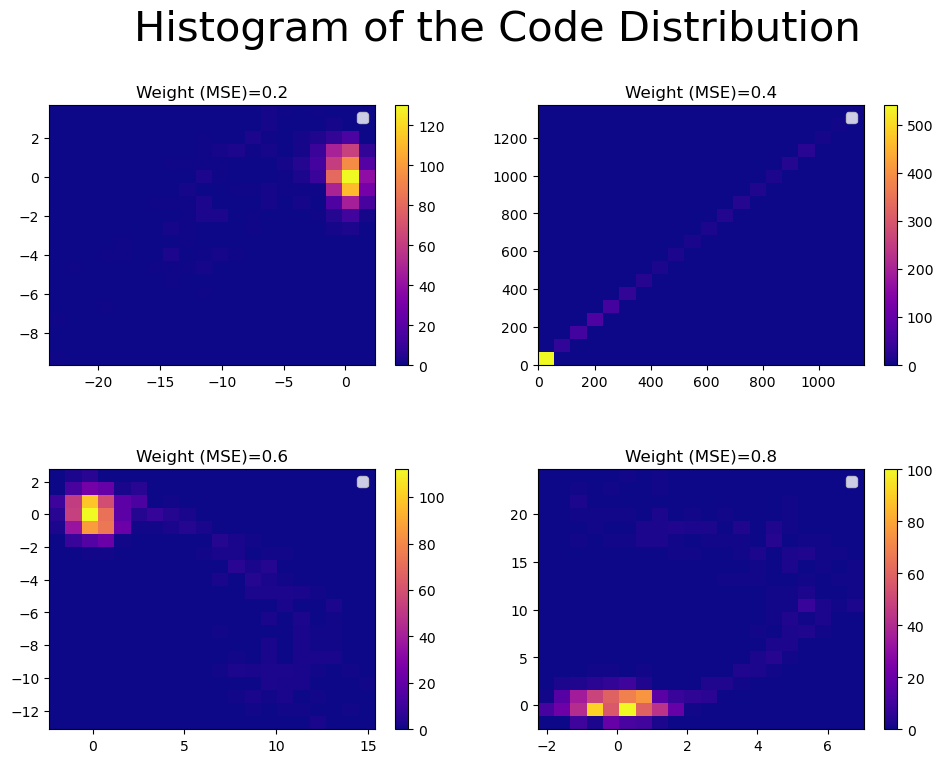

In [26]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):


    code=code_list[i].detach().numpy()

    hist=ax.hist2d(x=code[:,0], y=code[:,1], bins=20, cmap='plasma')
    fig.colorbar(hist[3], ax=ax)
    ax.legend()
    ax.set_title('Weight (MSE)='+str(weight_list[i]))

plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Histogram of the Code Distribution', y=1.5,fontsize=30)

plt.show()

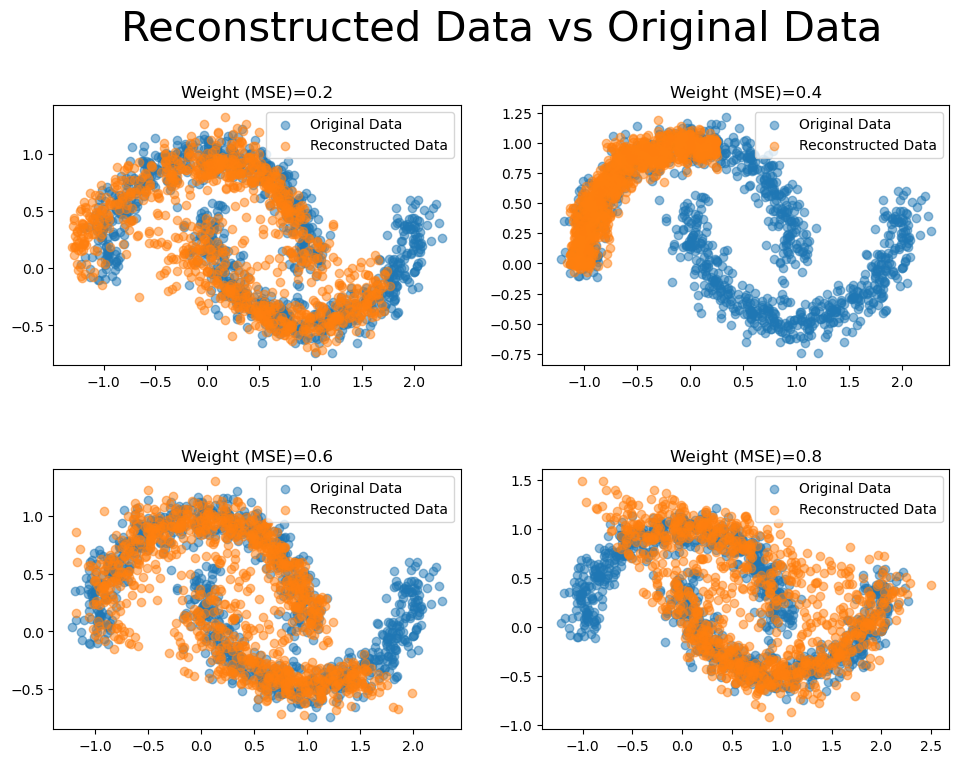

In [27]:
fig, axs = plt.subplots(2, 2,squeeze=False)
for i, ax in enumerate(axs.flat):
    loaded_state_dict = torch.load('model' +str(weight_list[i]) +'.pth')
    model.load_state_dict(loaded_state_dict)
    reconstructed_data = model.decode(samples)
    reconstructed_data = np.array([r.detach().numpy() for r in reconstructed_data])

    ax.scatter(X[:,0],X[:,1],label='Original Data', alpha=0.5)
    ax.scatter(reconstructed_data[:,0],reconstructed_data[:,1], label='Reconstructed Data', alpha=0.5)

    ax.legend()
    ax.set_title('Weight (MSE)='+str(weight_list[i]))


plt.subplots_adjust(left=-0.2, right=1.2, top=1.3, bottom=0, wspace=0.2, hspace=0.4)
fig.suptitle('Reconstructed Data vs Original Data', y=1.5,fontsize=30)

plt.show()

Task 3

In [64]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.1, n_test=0.5,  name="digits")

In [65]:
config={"input_size":  tune.choice([64]), "bottleneck_size":  tune.choice([8]),
        "hidden_size":  tune.choice([x for x in range(100, 600, 40)]), 
        "layers":  tune.choice([x for x in range(1, 5)]),
        "ts_size":  tune.choice([x for x in range(100, 1500, 100)]),
        "epochs":  tune.choice([x for x in range(400, 600)]),
        "lr": tune.choice([0.01, 0.001])}

good_config = opt(config)

2023-11-21 13:20:32,944	INFO tune.py:1045 -- Total run time: 107.46 seconds (107.42 seconds for the tuning loop).


The plot below shows the MSE reconstruction error vs the parameters. For hidden size, the size of the ts and the number of epochs, the error seems to stagnate. So increasing them after some point wont change anything. Some local optima can be spotted for the number of layers and the learning rate. Increasing the bottle neck size decreases the error drasticly.  

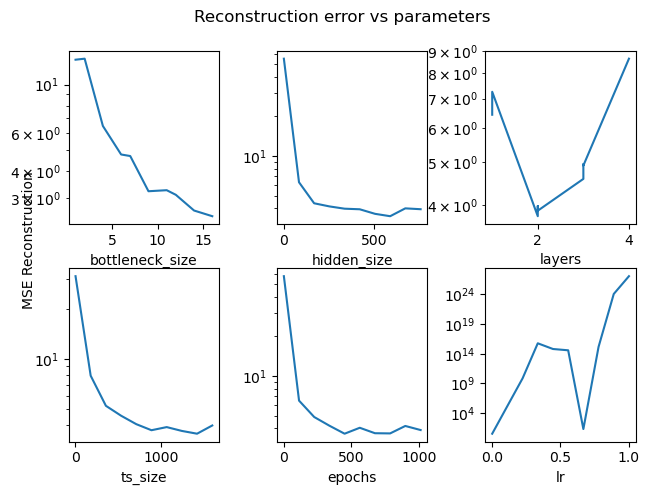

In [66]:
generate_plots()

The plot below shows the averaged error vs the bottleneck size. The error decays and will propably stagnate after dim(z) > 20.

1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
8
8
7
7
7
8
8
8
8
9
9
8
8
8
8
9
9
10
10
9
9
9
9
9
9
10
10
11
11
10
10
10
10
10
11
10
11
12
12
11
11
11
12
11
11
11
12
13
13
12
12
12
13
13
12
12
12
14
14
13
13
13
14
14
13
13
13
15
15
14
14
14
15
15
16
16
14
14
14
15
15
16
16
15
17
17
15
15
15
16
16
17
17
18
18
16
16
16
16
17
17
19
19
18
18
17
17
17
17
18
18
19
19
18
18
18
18
19
19
19
19
19
19
(19,)


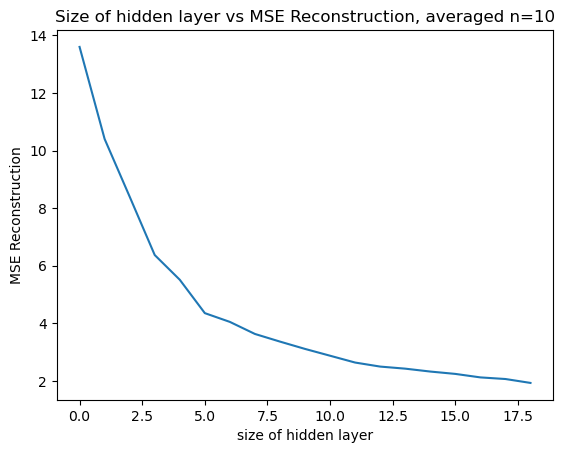

In [31]:
losses = []
def plot_loss_vs_hidden_size():
    loss = []
    for i in range(1, 20):
        print(i)
        auto, _ =  AutoEncoder(good_config["input_size"], i, 
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                           good_config["ts_size"], 
                                           good_config["epochs"], 
                                           good_config["lr"])
        loss.append(float(auto.calculate_loss(X_test).detach().numpy()))
    losses.append(np.array(loss))

n = 10
threads = []
for i in range(n):
    thread = threading.Thread(target=plot_loss_vs_hidden_size)
    thread.start()
    threads.append(thread)
[t.join() for t in threads]
plt.title(f"Size of hidden layer vs MSE Reconstruction, averaged n={n}")
plt.xlabel("size of hidden layer")
plt.ylabel("MSE Reconstruction")
loss = np.array([0 for x in range(len(losses[0]))])
print(loss.shape)
for l in losses:
    loss = np.add(loss, l)
loss = loss/n
plt.plot([x for x in range(len(loss))], loss)


The plot belows shows randomly selected digits from the data set and its reconstruction for different dim(z). It can be observed that with increasing dim(z), the reconstruction gets better. A simple explanation would be, that 2 dimensional codes are not sufficient to encode all the information per sample. 

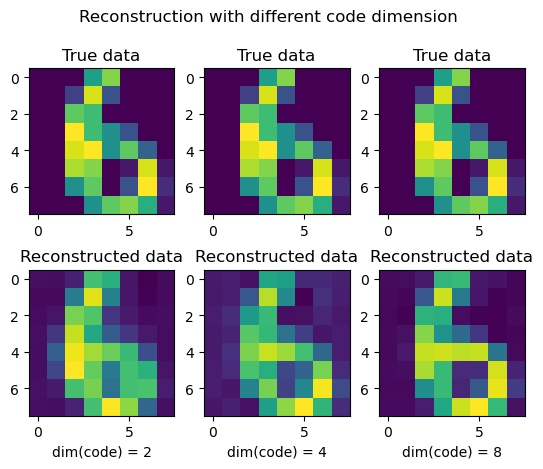

In [68]:
fig, axs = plt.subplots(2, 3)
fig.suptitle(f"Reconstruction with different code dimension")

j = 0
x = np.random.choice([i for i in range(len(X_test))])
x = X_test[x]
for i in [2, 4, 8]:
    auto, _ =  AutoEncoder(good_config["input_size"], i, 
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                           good_config["ts_size"], 
                                           good_config["epochs"], 
                                           good_config["lr"])
        
        

    axs[0, j].imshow(x.reshape(8,8))
    axs[0, j].set_title("True data")
    axs[1, j].imshow(auto.forward(x).detach().numpy().reshape(8, 8))
    axs[1, j].set_title("Reconstructed data")
    axs[1, j].set_xlabel(f"dim(code) = {i}")
    j += 1

The plot below shows, that the autoencoder does not yield the exact same results for the same parameters. Therefore there is always some variation in the results. This is due to random initialization of the weights and the random order and selection of the data set used for training.

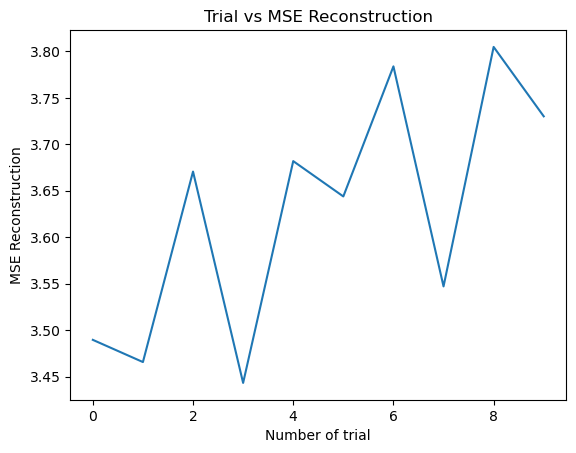

In [33]:
n = 10
plt.title(f"Trial vs MSE Reconstruction")
plt.xlabel("Number of trial")
plt.ylabel("MSE Reconstruction")
loss = []
for i in range(n):
    auto, _ =  AutoEncoder(good_config["input_size"],good_config["bottleneck_size"] , 
                                    good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                           good_config["ts_size"], 
                                           good_config["epochs"], 
                                           good_config["lr"])
    loss.append(float(auto.calculate_loss(X_test).detach().numpy()))

plt.plot(loss)


In [34]:
def get_z(X, auto=None, bs=None):
    if auto is None:
        auto, _ =  AutoEncoder(good_config["input_size"],(good_config["bottleneck_size"] if bs is None else bs), 
                                        good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                               good_config["ts_size"], 
                                               good_config["epochs"], 
                                               good_config["lr"])
    return auto, auto.encode(X)

In [35]:
def plot_synthetic_data(bs, k):
    if bs != 0:
        auto, Z_train = get_z(X_test, bs=bs)
        _, Z_test = get_z(X_train, auto=auto)

        Z_train = Z_test.detach().numpy()
        Z_test = Z_test.detach().numpy()
        scores = []
        for n in range(1, 50):
            scores.append(GMM(n_components = n).fit(Z_train).bic(Z_test))
        gmm = GMM(n_components= np.argmin(scores)).fit(Z_test)
        samples = torch.FloatTensor(gmm.sample(k**2)[0])
        synthetic_data = auto.decode(samples)
    else:
        synthetic_data = X_test
    fig, ax = plt.subplots(k,k)
    for i in range(k**2):
        ax.flatten()[i].imshow(synthetic_data[i].detach().numpy().reshape(8,8))

Here 4 by 4 codes get drawn from the gmm and reconstructed. First for dim(z) = 2, dim(z) = 4, dim(z) = 8 and 16 samples from the original data set for comparision. It can be observerd that with increasing 

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

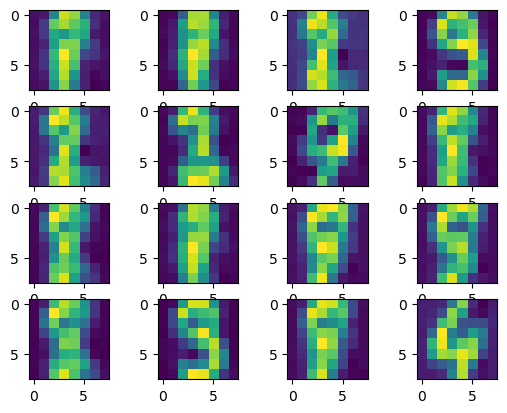

In [36]:
plot_synthetic_data(2, 4)

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

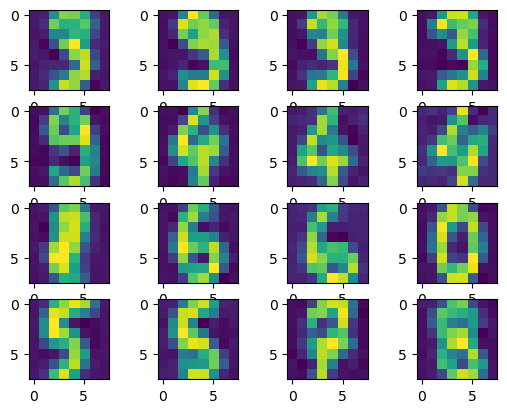

In [37]:
plot_synthetic_data(4, 4)

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak o

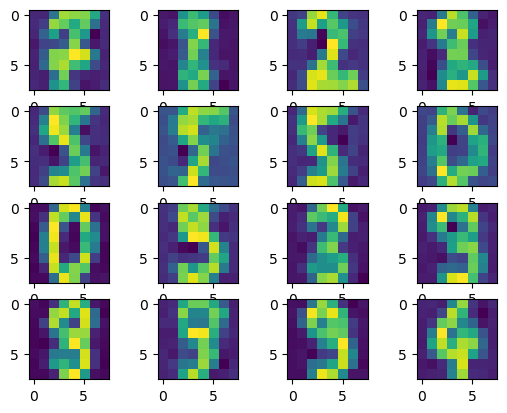

In [38]:
plot_synthetic_data(8, 4)

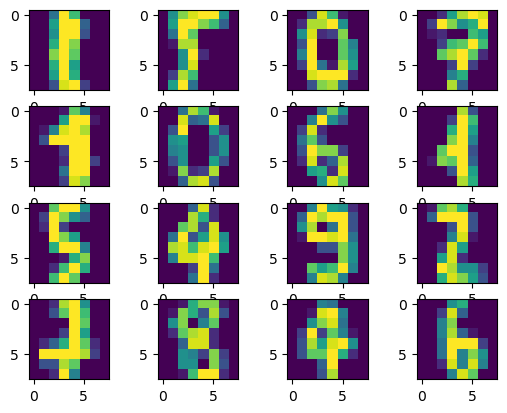

In [39]:
plot_synthetic_data(0, 4)

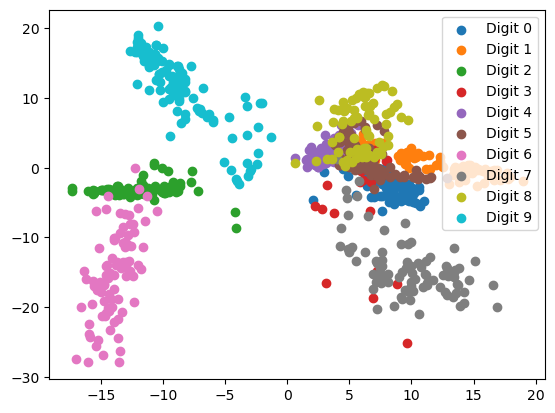

In [40]:
for i in range(10):
    _, z = get_z(X_test[np.where(Y_test == i)], bs=2)
    z = z.detach().numpy()
    plt.scatter(z.T[0], z.T[1], label=f"Digit {i}")
plt.legend()

In [42]:
def train_rfc(data, targets):
    p_grid = {"n_estimators":[100 * x for x in range(4)], "criterion" : ["gini", "entropy", "log_loss"], 
                             "max_features": ["sqrt", "log2", None]}
    rfc = HalvingGridSearchCV(RFC(), p_grid, refit=True, verbose=1, cv=3).fit(data, targets)
    return rfc.best_estimator_


In [43]:
rfc = train_rfc(X_train, Y_train)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 60
max_resources_: 898
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 60
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Florian\anaconda3\Lib\sit

----------
iter: 1
n_candidates: 12
n_resources: 180
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.69210526 0.65877193 0.6754386         nan 0.69298246
 0.69385965 0.67631579        nan 0.57017544 0.62368421 0.60526316
        nan 0.70964912 0.6745614  0.69298246        nan 0.71052632
 0.67631579 0.67631579        nan 0.67368421 0.64035088 0.69210526
        nan 0.72894737 0.70964912 0.63947368        nan 0.70964912
 0.69298246 0.71052632        nan 0.63947368 0.65789474 0.63859649
 0.89312618 0.89303202 0.90433145 0.89868173 0.88766478 0.89303202
 0.8873823  0.89877589 0.89312618 0.88747646 0.87052731 0.88182674]
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.
  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1.
  1.  1. 

----------
iter: 2
n_candidates: 4
n_resources: 540
Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.69210526 0.65877193 0.6754386         nan 0.69298246
 0.69385965 0.67631579        nan 0.57017544 0.62368421 0.60526316
        nan 0.70964912 0.6745614  0.69298246        nan 0.71052632
 0.67631579 0.67631579        nan 0.67368421 0.64035088 0.69210526
        nan 0.72894737 0.70964912 0.63947368        nan 0.70964912
 0.69298246 0.71052632        nan 0.63947368 0.65789474 0.63859649
 0.89312618 0.89303202 0.90433145 0.89868173 0.88766478 0.89303202
 0.8873823  0.89877589 0.89312618 0.88747646 0.87052731 0.88182674
 0.95353818 0.94795158 0.95542106 0.95912477]
  warnings.warn(
C:\Users\Florian\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the train scores are non-finite: [nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.  1.  1. nan  1.
  1.  1. nan  1.  1.  1. nan  1.  1. 

In [44]:
rfc.score(X_test, Y_test)

0.9699666295884316

In [45]:
def reconstruction_quality():
    fig, ax = plt.subplots(1, 3)
    j = 0
    for i in [2,4,8]:
        auto, _ =  AutoEncoder(good_config["input_size"],i, 
                                            good_config["hidden_size"], good_config["layers"]).train_autoencoder(X_train, 
                                                   good_config["ts_size"], 
                                                   good_config["epochs"], 
                                                   good_config["lr"])
        reconstructed = auto.forward(X_test).detach().numpy()
        predictions = rfc.predict(reconstructed)
        diff = Y_test - predictions
        correct = len(np.where(abs(diff) <= 1E-8)[0])
        false = len(Y_test) - correct
        ax[j].bar(["right", "wrong"], [correct, false])
        j += 1
    
    

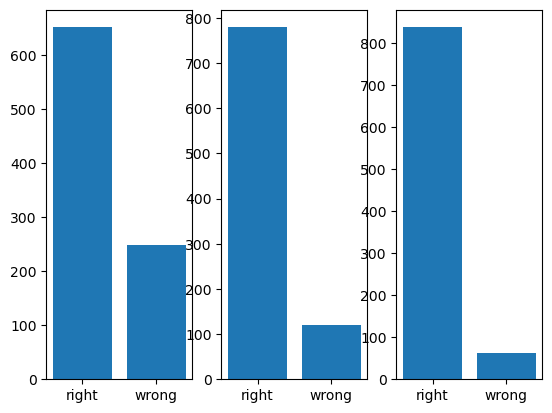

In [46]:
reconstruction_quality()